환경

cos세타 (cosθ): 이것은 펜듈럼의 현재 각도, 코사인으로 변환한 값입니다. 펜듈럼이 수직 아래로 향할 때 cosθ는 1이고, 수직 위로 향할 때 -1

sin세타 (sinθ): 이것은 펜듈럼의 현재 각도, 사인으로 변환한 값입니다. 펜듈럼이 수평으로 왼쪽이나 오른쪽으로 가장 멀리 뻗어 있을 때 sinθ는 각각 1 또는 -1

각속도: 이것은 펜듈럼이 회전하는 속도 ,양수일 때는 시계 방향으로, 음수일 때는 반시계 방향으로 회전하고 있음을 의미

보상
보상=−(θ
2
 +0.1×각속도
2
 +0.001×토크
2
 )
수직 위로 유지하면서도 적은 힘을 사용하고, 움직임을 부드럽게 유지하는가

### 정책 클래스

평균과 표준편차를 이용하여 정책을 업데이트하는 신경망이 있는 클래스

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym

class Policy(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Policy, self).__init__()
        self.input_layer = nn.Linear(state_dim, 512)
        self.mu_layer = nn.Linear(512, action_dim)
        self.log_std_layer = nn.Linear(512, action_dim)

        nn.init.zeros_(self.input_layer.bias.data)
        nn.init.zeros_(self.mu_layer.bias.data)
        nn.init.zeros_(self.log_std_layer.bias.data)

        nn.init.orthogonal_(self.input_layer.weight.data, nn.init.calculate_gain('relu'))
        nn.init.orthogonal_(self.mu_layer.weight.data, nn.init.calculate_gain('linear'))
        nn.init.orthogonal_(self.log_std_layer.weight.data, nn.init.calculate_gain('tanh'))

    def forward(self, x):
        x = F.relu(self.input_layer(x))

        mu = self.mu_layer(x)
        log_std = torch.tanh(self.log_std_layer(x)) #로그 표준편차(log_std)를 계산하고 tanh 함수를 적용하여 -1과 1 사이의 값으로 정규화

        return mu, log_std.exp()


### 리인포스 클래스

에피소드에 대한 메모리를 저장하고 이를 바탕으로 로스가 낮아지게 학습하는 클래스

In [ ]:
class REINFORCE:
    def __init__(self, state_dim, action_dim, gamma=0.9):
        self.policy = Policy(state_dim, action_dim)
        self.gamma = gamma

        self.policy_optimizer = torch.optim.Adam(self.policy.parameters(), lr=0.0003)
        self.buffer = []

    @torch.no_grad() #미분 미사용
    def act(self, s, training=True): #학습모드
        self.policy.train(training)

        s = torch.as_tensor(s).float() # 상태 텐서변환
        mu, std = self.policy(s) # 정책 네트워크를 통해 상태 s에 대한 액션의 평균과 표준 편차를 얻음
        z = torch.normal(mu, std) if training else mu
        a = torch.tanh(z) # 액션 -1과 1사이로 제한

        return a.numpy()

    def learn(self):
        # [(s_1, a_1, r_1), (s_2, a_2_r_2), ... ]를 (s_1, s_2, ...), (a_1, a_2, ...), (r_1, r_2, ...)로 변환
        s, a, r = map(np.stack, zip(*self.buffer)) # 버퍼에서 sar 추출

        # G_t 만들어주기
        G = np.copy(r)
        for t in reversed(range(len(r) - 1)):
            G[t] += self.gamma * G[t + 1]
        s, a, G = map(lambda x: torch.as_tensor(x).float(), [s, a, G])
        G = G.unsqueeze(1)  # 열벡터 만들어주기

        # log prob 만들기
        mu, std = self.policy(s) #정책 네트워크를 통해 상태 s에 대한 액션의 평균과 표준 편차 얻기
        m = torch.distributions.Normal(mu, std) # 정규분포 생성
        z = torch.atanh(torch.clip(a, -1.0 + 1e-7, 1.0 - 1e-7))  # torch.atanh(-1.0), torch.atanh(1.0)은 각각 -infty, infty라서 clipping 필요
        log_prob = m.log_prob(z)

        # 손실함수 만들기 및 역전파
        policy_loss = - (log_prob * G).mean() # 어센트
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()

    def process(self, s, a, r, done):
        self.buffer.append((s, a, r)) # 버퍼에추가
        if done:
            self.learn() # 수집된걸로 학습
            self.buffer = [] # 버퍼 비우기

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


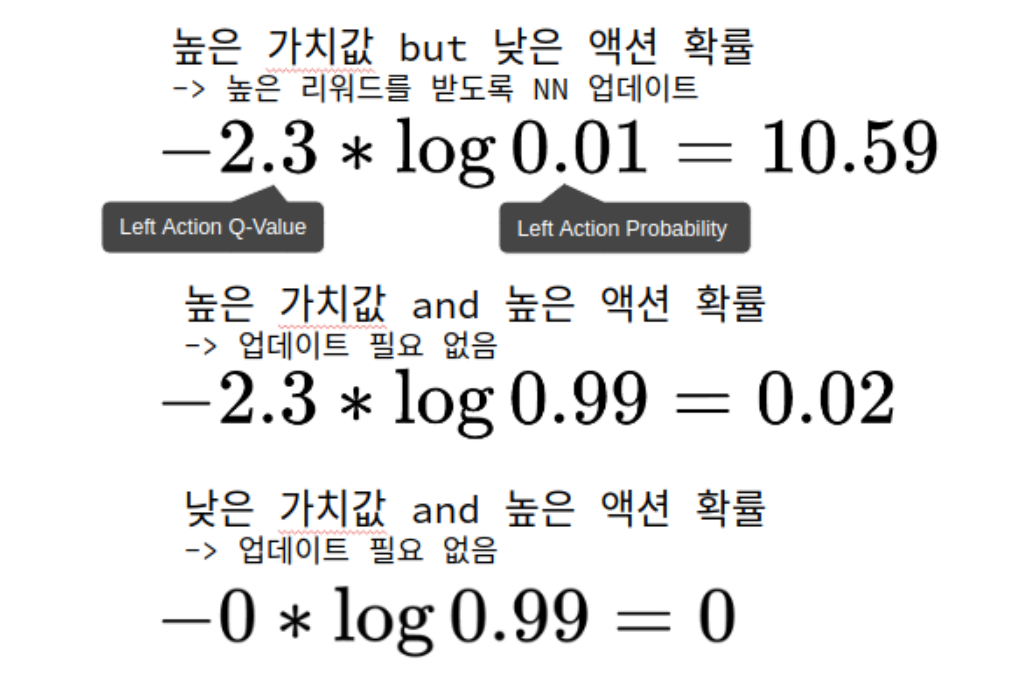

In [ ]:
num_seeds = 10  # 에이전트를 여러 번 초기화하여 다양한 초기 상태에서 학습을 수행하기 위한 시드의 수

max_iterations = 1000  # 전체 학습 반복 횟수. 에이전트가 환경과 상호 작용하는 총 횟수

eval_intervals = 5000  # 일정 간격으로 평가를 수행하기 위한 반복 횟수 간격

eval_iterations = 10  # 각 평가에서 에이전트의 성능을 평가할 때 사용하는 반복 횟수

In [ ]:
import torch
import random
import numpy as np

def seed_all(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

### 평가 메서드

일정 이터레이션에서 정책을 평가하는 메서드

그래프의 용도 업데이트에는 영향을 주지 않음

In [ ]:
def evaluate(env_name, agent, seed, eval_iterations):
    env = gym.make(env_name)
    env.seed(seed + 9999)
    scores = []
    for _ in range(eval_iterations):
        s, done, ret = env.reset(), False, 0 # 상태, 종료여부, 누적보상
        while not done:
            a = agent.act(s, training=False) # 평가모드
            s_prime, r, done, info = env.step(2.0 * a) # a 에대해 , 새로 얻는 값들
            ret += r
            s = s_prime
        scores.append(ret) # 리스트에 누적보상 추가
    env.close()
    return round(np.mean(scores), 4) # 모든 에피소드 누적 보상의 평균을 계산

시각화때 사용될 라이브러리 설치

In [ ]:
!pip install wandb
!apt-get install x11-utils
!pip install pyglet
!apt-get install -y xvfb python-opengl

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
x11-utils is already the newest version (7.7+5build2).
0 upgraded, 0 newly installed, 0 to remove and 9 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-opengl


환경을 지정

In [ ]:
import gym
import wandb

env_name = 'Pendulum-v1'
agent_name = 'REINFORCE2'

이터레이션 만큼 학습을 진행

wandb 에 그래프를 작성


In [ ]:
for seed in range(num_seeds):
    wandb.init(project=env_name, group=agent_name, name=f'seed {seed}')
    seed_all(seed)
    env = gym.make(env_name)
    env.seed(seed)

    state_dim = env.observation_space.shape[0] # 행동 공간
    action_dim = env.action_space.shape[0] # 액션공간

    agent = REINFORCE(state_dim, action_dim)

    s, done, ret = env.reset(), False, 0
    for t in range(1, max_iterations + 1): # 이터레이션 반복
        a = agent.act(s) # s를 입력으로 주어 행동 a를 선택하도록
        s_prime, r, done, _ = env.step(2.0 * a) #s_prime, 보상 r, 종료 여부 done
        agent.process(s, a, r, done)
        s = s_prime

        if done:
            s, done, ret = env.reset(), False, 0

        if t % eval_intervals == 0:
            score = evaluate(env_name, agent, seed, eval_iterations)
            wandb.log({'Steps': t, 'AvgEpRet': score})

    wandb.finish()

wandb: Currently logged in as: oylim982. Use `wandb login --relogin` to force relogin


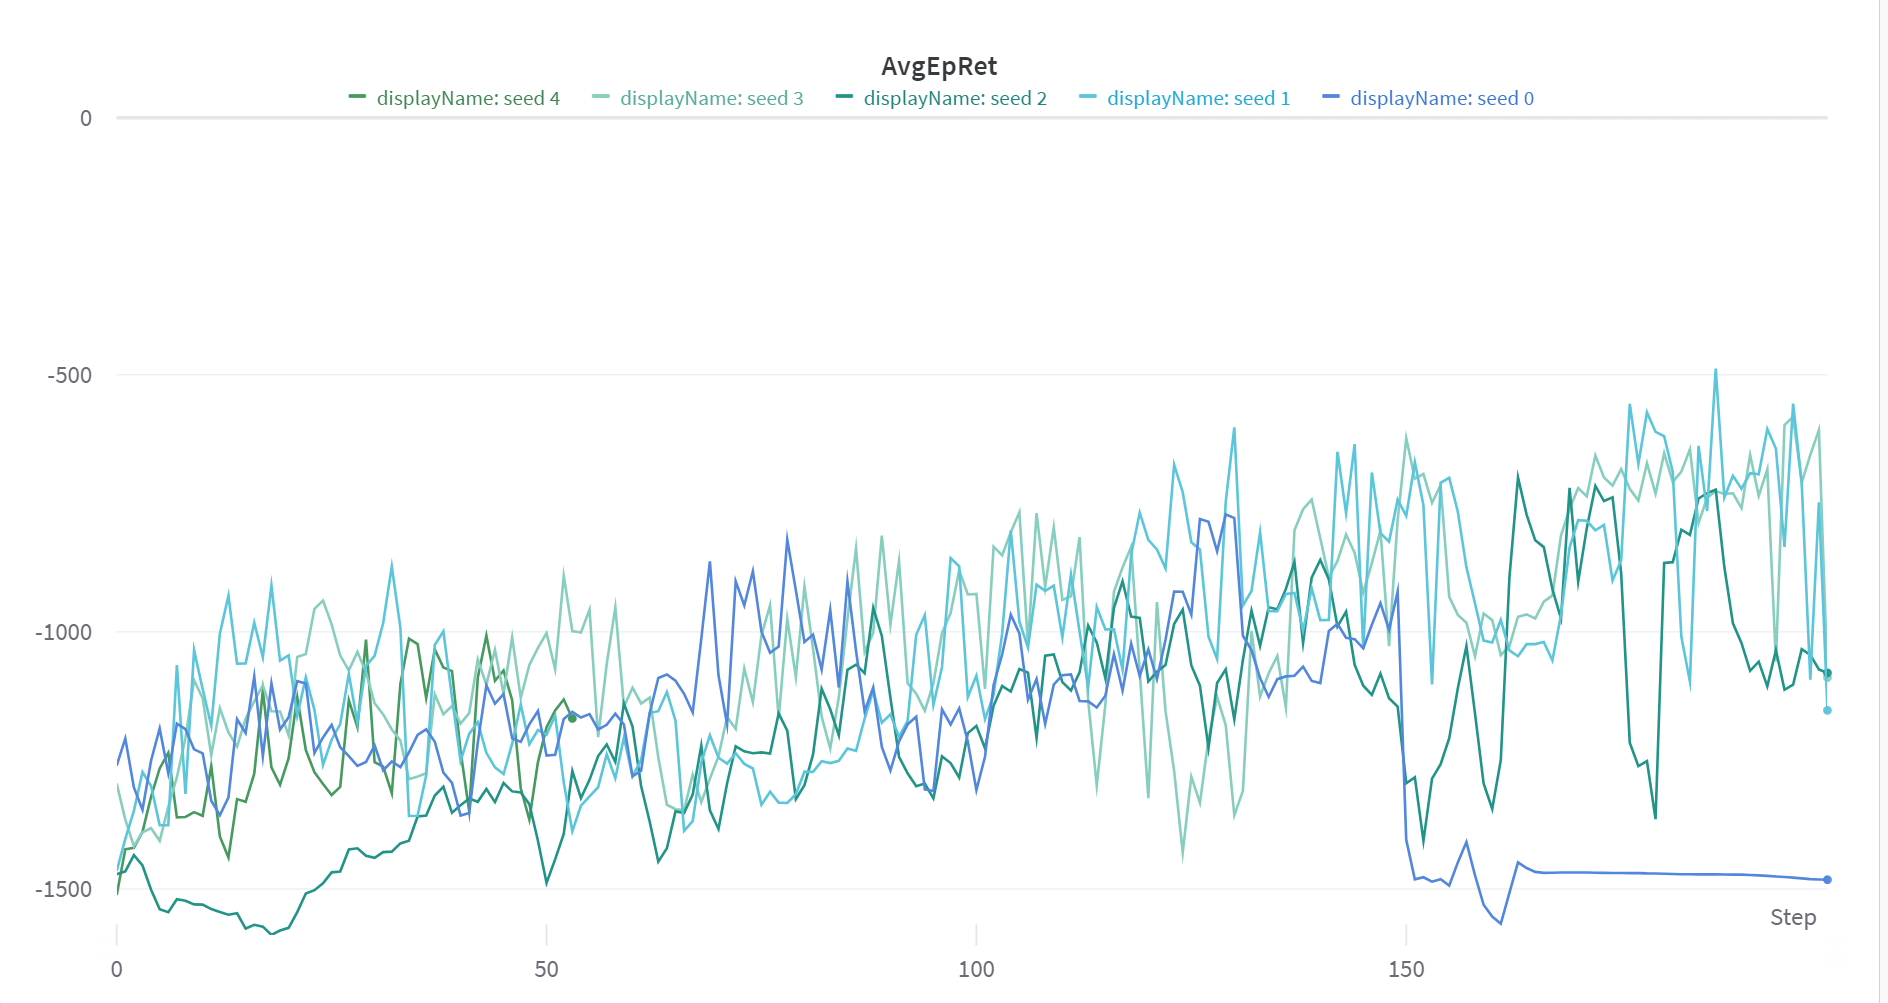

### 학습 시각화용 코드

학습 매 프레임 출력 및 비디오 저장

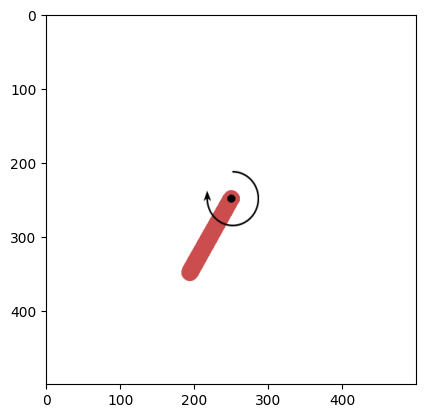

In [ ]:
import gym
import matplotlib.pyplot as plt
import pygame
from IPython import display as ipythondisplay
from IPython.lib.pretty import Breakable
import imageio

env.reset()
pygame.init()

prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)


frames = []  # 저장될 프레임

# 메인루프
for seed in range(num_seeds):
    seed_all(seed)
    env = gym.make(env_name)
    env.seed(seed)

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    agent = REINFORCE(state_dim, action_dim)

    s = env.reset()
    for t in range(1, max_iterations + 1):
        a = agent.act(s)
        s_prime, r, done, _ = env.step(2.0 * a)
        agent.process(s, a, r, done)
        s = s_prime

        # 화면 렌더링 및 프레임 저장
        frame = env.render(mode='rgb_array')
        frames.append(frame)
        plt.imshow(frame)
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())

        if done:
            s = env.reset()

env.close()

imageio.mimsave('gym_animation.mp4', frames, fps=20)

동영상

In [11]:
from IPython.display import HTML

embed_code = """
<div style="width:100%;height:0px;position:relative;padding-bottom:102.273%;">
<iframe src="https://streamable.com/e/lj3db2" frameborder="0" width="100%" height="100%" allowfullscreen style="width:100%;height:100%;position:absolute;left:0px;top:0px;overflow:hidden;"></iframe>
</div>
"""

HTML(embed_code)
